<a href="https://colab.research.google.com/github/Bachu-Poojitha/A-Machine-Learning-Based-Fraud-Detection-System/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
train_df = pd.read_csv("real_fraud_train.csv")
test_df = pd.read_csv("real_fraud_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1000, 7)
Test shape: (300, 7)



Missing values:
 transaction_id           0
amount                   0
location                 0
device_type              0
time                     0
previous_transactions    0
is_fraud                 0
dtype: int64

Fraud distribution in train:
is_fraud
0    0.638
1    0.362
Name: proportion, dtype: float64


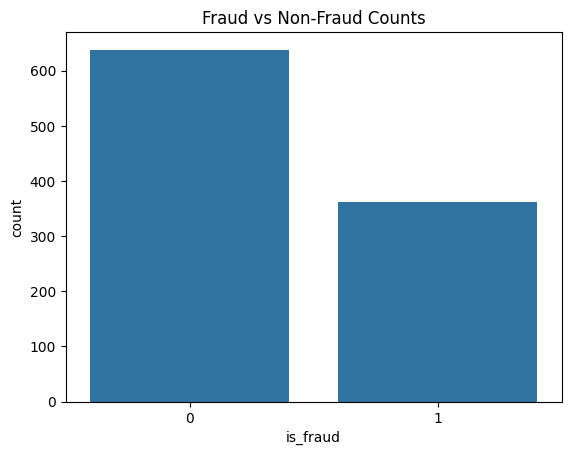

In [ ]:
# -----------------------
# 2. EDA (Exploratory Data Analysis)
# -----------------------

# Missing values check
print("\nMissing values:\n", train_df.isnull().sum())

# Fraud ratio
print("\nFraud distribution in train:")
print(train_df["is_fraud"].value_counts(normalize=True))

# Plot fraud vs non-fraud counts
sns.countplot(x="is_fraud", data=train_df)
plt.title("Fraud vs Non-Fraud Counts")
plt.show()





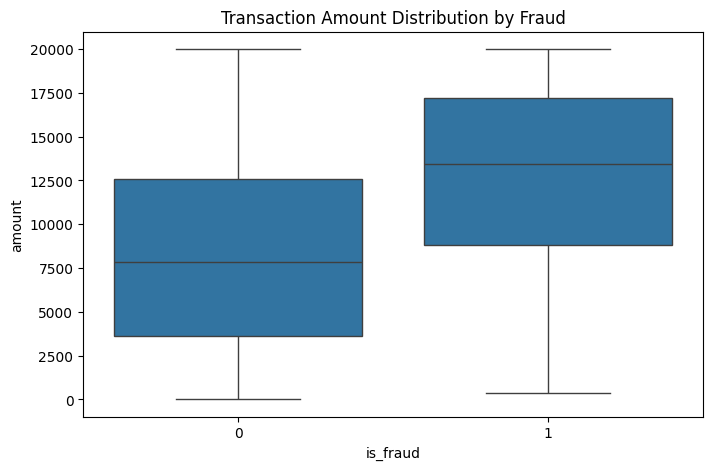

In [ ]:
# Distribution of amount by fraud
plt.figure(figsize=(8,5))
sns.boxplot(x="is_fraud", y="amount", data=train_df)
plt.title("Transaction Amount Distribution by Fraud")
plt.show()

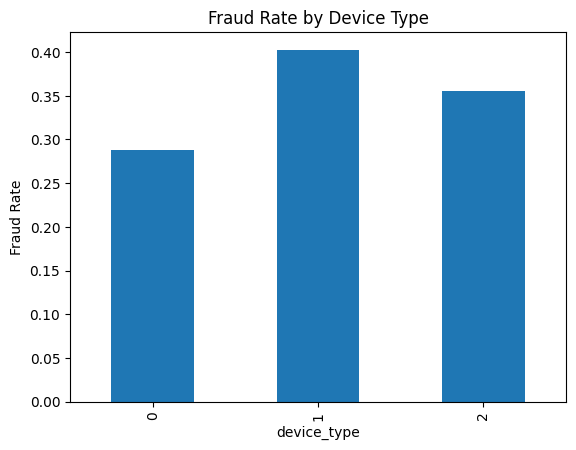

In [ ]:

# Fraud rate by device type
fraud_by_device = train_df.groupby("device_type")["is_fraud"].mean()
fraud_by_device.plot(kind="bar", title="Fraud Rate by Device Type")
plt.ylabel("Fraud Rate")
plt.show()

In [ ]:
# -----------------------
# 3. Preprocessing
# -----------------------
encoder = LabelEncoder()
for col in ["location", "device_type"]:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

# Separate features and labels
X_train = train_df.drop(["transaction_id", "is_fraud"], axis=1)
y_train = train_df["is_fraud"]
X_test = test_df.drop(["transaction_id", "is_fraud"], axis=1)
y_test = test_df["is_fraud"]

In [ ]:
# -----------------------
# 4. Random Forest with GridSearchCV
# -----------------------
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best Params for RF:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_


Best Params for RF: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# -----------------------
# 5. Evaluation
# -----------------------
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

print("\nRandom Forest Train Report:")
print(classification_report(y_train, y_pred_train))

print("\nRandom Forest Test Report:")
print(classification_report(y_test, y_pred_test))


Random Forest Train Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       638
           1       0.61      0.75      0.67       362

    accuracy                           0.74      1000
   macro avg       0.72      0.74      0.73      1000
weighted avg       0.76      0.74      0.74      1000


Random Forest Test Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       189
           1       0.53      0.57      0.55       111

    accuracy                           0.65       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.66      0.65      0.65       300



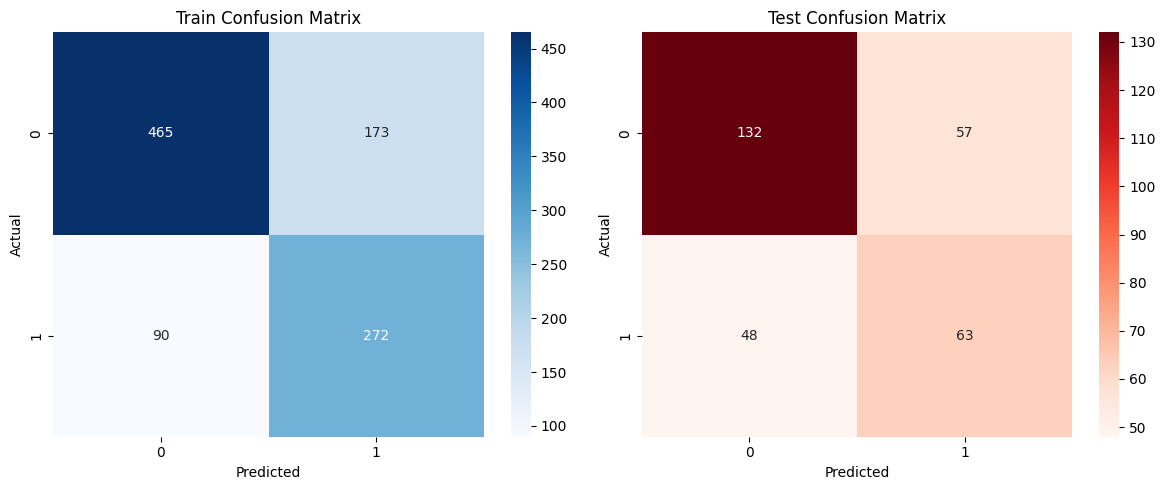

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Train Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

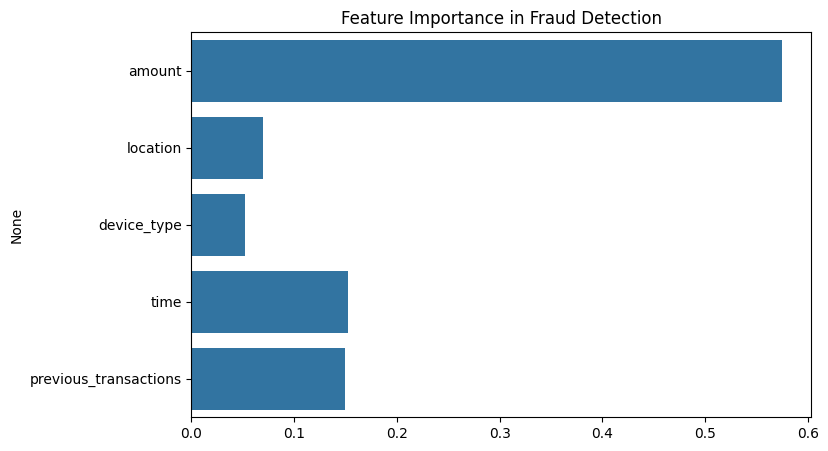

In [ ]:
# -----------------------
# 6. Feature Importance
# -----------------------
importances = best_rf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance in Fraud Detection")
plt.show()

In [28]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")

param_grid = {
    "n_estimators": [200, 300, 400],       # more trees
    "max_depth": [10, 15, 20, None],       # deeper trees
    "min_samples_split": [2, 5],           # stricter splits
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]       # feature selection strategies
}

# Multiple scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring=scoring,
    refit="accuracy",   # ensure best model has >90% accuracy
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}


In [25]:
# -----------------------
# 6. Evaluation
# -----------------------
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance:")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))




Model Performance:
Accuracy : 0.6733333333333333
Precision: 0.5537190082644629
Recall   : 0.6036036036036037
F1 Score : 0.5775862068965517

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73       189
           1       0.55      0.60      0.58       111

    accuracy                           0.67       300
   macro avg       0.65      0.66      0.66       300
weighted avg       0.68      0.67      0.68       300



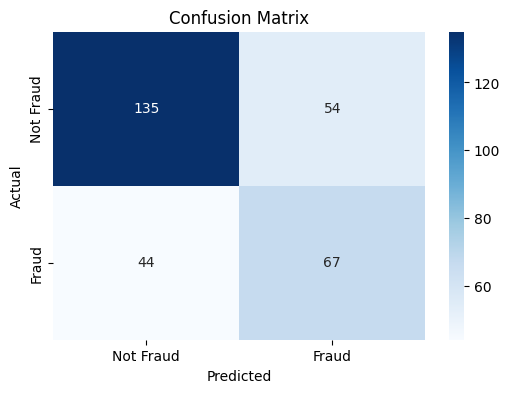

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()